## Tests using DeepFloyd-IF

DeepFloyds-IF is a pixel-based open-source text-to-image generation model inspired by Google's Imagen. It operates directly in pixel space and uses the powerful T5-XXL text encoder, leading to better image generation with high-frequency details and reliable text rendering compared to models like Stable Diffusion. However, IF's enhanced capabilities come with a significant increase in parameters, making it more resource-intensive.

Running DeepFloyd's IF model on the free-tier Google Colab is challenging due to its constraints on CPU RAM (13 GB) and GPU VRAM (15 GB).Using bitsandbytes 8-bit quantization for the T5 text encoder reduces its size to 8 GB, fitting within CPU and GPU memory limits. To manage memory efficiently, diffusers can modularly load individual components as needed, ensuring each component has sufficient resources during its step in the pipeline.

The code in this notebook is adapted from the google collab notebook from the official model page for DeepFloyd-IF on Hugging Face.



In [ ]:
!grep MemTotal /proc/meminfo

MemTotal:       55534096 kB


In [ ]:
!nvidia-smi

Sun Jul 28 21:19:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   39C    P8              16W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Install required modules

! pip install --upgrade \
  diffusers~=0.16 \
  transformers~=4.28 \
  safetensors~=0.3 \
  sentencepiece~=0.1 \
  accelerate~=0.31.0 \
  bitsandbytes~=0.38 \
  torch==2.3.1 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 52.6 MB/s eta 0:00:00


In [ ]:
from huggingface_hub import login

login()

## Text embeddings

In [ ]:
# Load the text encoder

from transformers import T5EncoderModel

# !pip install -U bitsandbytes
# !pip install accelerate

text_encoder = T5EncoderModel.from_pretrained(
    "DeepFloyd/IF-I-XL-v1.0",
    subfolder="text_encoder",
    device_map="auto",
    load_in_8bit=True,
    variant="8bit"
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


In [ ]:
# Create text embeddings

from diffusers import DiffusionPipeline

pipe = DiffusionPipeline.from_pretrained(
    "DeepFloyd/IF-I-XL-v1.0",
    text_encoder=text_encoder, # pass the previously instantiated 8bit text encoder
    unet=None,
    device_map="balanced"
)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
prompt = 'A library at midnight under a sky filled with stars with the words \"The Midnight Library\" superimposed on the image.'

In [ ]:
prompt_embeds, negative_embeds = pipe.encode_prompt(prompt)

In [ ]:
# Free memory

del text_encoder
del pipe

In [ ]:
import gc
import torch

def flush():
  gc.collect()
  torch.cuda.empty_cache()

In [ ]:
flush()

## Stage 1: The main diffusion process

In [ ]:
# Load the pipeline

pipe = DiffusionPipeline.from_pretrained(
    "DeepFloyd/IF-I-XL-v1.0",
    text_encoder=None,
    variant="fp16",
    torch_dtype=torch.float16,
    device_map="balanced"
)


A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[text_encoder/model.fp16-00001-of-00002.safetensors, unet/diffusion_pytorch_model.fp16.safetensors, safety_checker/model.fp16.safetensors, text_encoder/model.fp16-00002-of-00002.safetensors]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.safetensors
If this behavior is not expected, please check your folder structure.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
# Seed the generator

generator = torch.Generator().manual_seed(5)
image = pipe(
    prompt_embeds=prompt_embeds,
    negative_prompt_embeds=negative_embeds,
    output_type="pt",
    generator=generator,
).images

  0%|          | 0/100 [00:00<?, ?it/s]

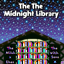

In [ ]:
# Result of the first stage

from diffusers.utils import pt_to_pil

pil_image = pt_to_pil(image)
pipe.watermarker.apply_watermark(pil_image, pipe.unet.config.sample_size)

pil_image[0]

In [ ]:
# Free memory
del pipe
flush()

## Stage 2: Super Resolution 64x64 to 256x256

In [ ]:
pipe = DiffusionPipeline.from_pretrained(
    "DeepFloyd/IF-II-L-v1.0",
    text_encoder=None, # no use of text encoder => memory savings!
    variant="fp16",
    torch_dtype=torch.float16,
    device_map="balanced"
)


A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[text_encoder/model.fp16-00001-of-00002.safetensors, unet/diffusion_pytorch_model.fp16.safetensors, safety_checker/model.fp16.safetensors, text_encoder/model.fp16-00002-of-00002.safetensors]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.safetensors
If this behavior is not expected, please check your folder structure.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
image = pipe(
    image=image,
    prompt_embeds=prompt_embeds,
    negative_prompt_embeds=negative_embeds,
    output_type="pt",
    generator=generator,
).images

  0%|          | 0/50 [00:00<?, ?it/s]

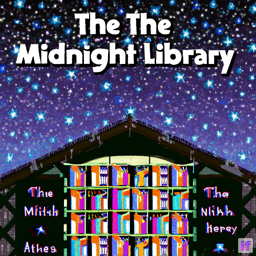

In [ ]:
# Result of the second stage

pil_image = pt_to_pil(image)
pipe.watermarker.apply_watermark(pil_image, pipe.unet.config.sample_size)

pil_image[0]

In [ ]:
# Free memory
del pipe
flush()

## Stage 3: Super Resolution 256x256 to 1024x1024

In [ ]:
# Load the pipline - This part is not working

pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-x4-upscaler",
    torch_dtype=torch.float16,
    device_map="balanced"
)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Taking `'Attention' object has no attribute 'key'` while using `accelerate.load_checkpoint_and_dispatch` to mean /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-x4-upscaler/snapshots/572c99286543a273bfd17fac263db5a77be12c4c/vae was saved with deprecated attention block weight names. We will load it with the deprecated attention block names and convert them on the fly to the new attention block format. Please re-save the model after this conversion, so we don't have to do the on the fly renaming in the future. If the model is from a hub checkpoint, please also re-upload it or open a PR on the original repository.


TypeError: load_checkpoint_and_dispatch() got an unexpected keyword argument 'force_hook'

In [ ]:
# The x4 Upscaler does not use T5 and has its own text encoder. Therefore, we cannot use the previously created prompt embeddings and instead must pass the original prompt.

pil_image = pipe(prompt, generator=generator, image=image).images

In [ ]:
from diffusers.pipelines.deepfloyd_if import IFWatermarker

watermarker = IFWatermarker.from_pretrained("DeepFloyd/IF-I-XL-v1.0", subfolder="watermarker")
watermarker.apply_watermark(pil_image, pipe.unet.config.sample_size)

pil_image[0]